In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [2]:
project_name='cifar10-cnn'

In [3]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [4]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [5]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['truck', 'ship', 'dog', 'airplane', 'bird', 'deer', 'cat', 'horse', 'frog', 'automobile']


In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [7]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


bird


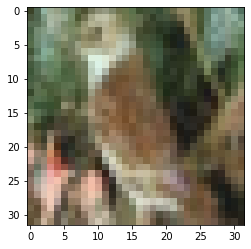

In [9]:
img,label=dataset[11001]
plt.imshow(img.permute(1,2,0));
print(dataset.classes[label])

In [10]:
len(dataset)

50000

In [11]:
random_seed = 42
torch.manual_seed(random_seed);

In [12]:
train_size=45000
val_size=5000
train_ds,val_ds=random_split(dataset,[train_size,val_size])

truck


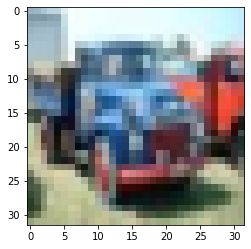

In [13]:
img,label=train_ds[11001]
plt.imshow(img.permute(1,2,0));
print(dataset.classes[label])

In [14]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 10))
        # ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

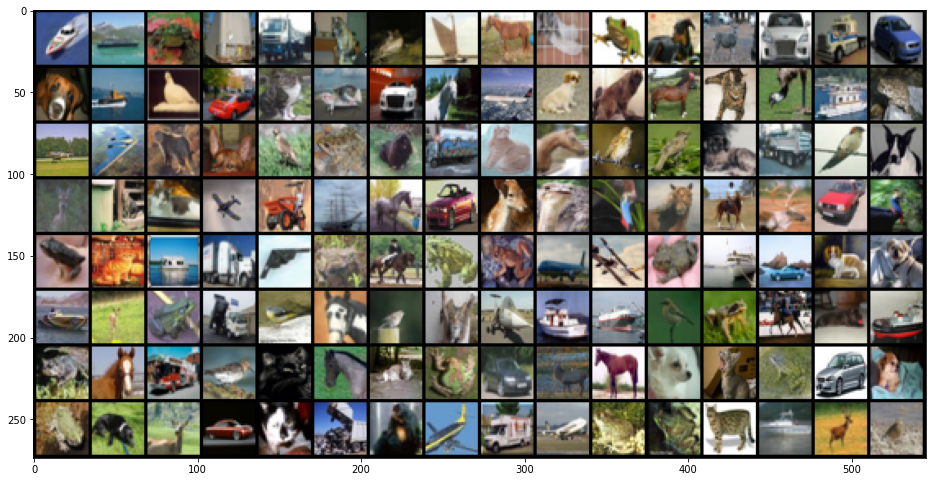

In [16]:
show_batch(train_dl)

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
class Cifar10CnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network=nn.Sequential(
        #input: 3 x 32 x 32
        nn.Conv2d(3,32,kernel_size=3,padding=1),
        #output:32 x 32 x 32
        nn.ReLU(),
        #output: 32 x 32 x 32
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        #output: 64 x 32 x 32
        nn.MaxPool2d(2,2),
        # output: 64 x 16 x 16

        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        #output: 256 x 4 x 4

        nn.Flatten(),
        nn.Linear(256*4*4,1024),
        nn.ReLU(),
        nn.Linear(1024,128),
        nn.ReLU(),
        nn.Linear(128,10))
    
  def forward(self,xb):
    return self.network(xb)    

In [20]:
model=Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0448, -0.0722,  0.0116,  0.0634,  0.0271, -0.0524,  0.0778,  0.0790,
         0.0295,  0.0124], grad_fn=<SelectBackward0>)


In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

**Training the Model**

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
model=to_device(Cifar10CnnModel(),device)
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [27]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [28]:
history = fit(num_epochs, lr, model, train_dl, val_dl,opt_func)

Epoch [0], train_loss: 1.7324, val_loss: 1.4007, val_acc: 0.4846
Epoch [1], train_loss: 1.2293, val_loss: 1.0721, val_acc: 0.6186
Epoch [2], train_loss: 0.9741, val_loss: 0.9207, val_acc: 0.6709
Epoch [3], train_loss: 0.7919, val_loss: 0.7798, val_acc: 0.7270
Epoch [4], train_loss: 0.6380, val_loss: 0.7513, val_acc: 0.7385
Epoch [5], train_loss: 0.5237, val_loss: 0.6942, val_acc: 0.7677
Epoch [6], train_loss: 0.4055, val_loss: 0.6972, val_acc: 0.7741
Epoch [7], train_loss: 0.3101, val_loss: 0.7863, val_acc: 0.7715
Epoch [8], train_loss: 0.2240, val_loss: 0.8342, val_acc: 0.7846
Epoch [9], train_loss: 0.1708, val_loss: 0.9408, val_acc: 0.7774


In [29]:
history+=fit(num_epochs, lr, model, train_dl, val_dl,opt_func)

Epoch [0], train_loss: 0.1356, val_loss: 1.0623, val_acc: 0.7825
Epoch [1], train_loss: 0.0968, val_loss: 1.1779, val_acc: 0.7602
Epoch [2], train_loss: 0.0965, val_loss: 1.1191, val_acc: 0.7772
Epoch [3], train_loss: 0.0723, val_loss: 1.2027, val_acc: 0.7683
Epoch [4], train_loss: 0.0745, val_loss: 1.3244, val_acc: 0.7750
Epoch [5], train_loss: 0.0682, val_loss: 1.3845, val_acc: 0.7678
Epoch [6], train_loss: 0.0654, val_loss: 1.4143, val_acc: 0.7727
Epoch [7], train_loss: 0.0603, val_loss: 1.3861, val_acc: 0.7784
Epoch [8], train_loss: 0.0665, val_loss: 1.2592, val_acc: 0.7836
Epoch [9], train_loss: 0.0576, val_loss: 1.4397, val_acc: 0.7700


In [30]:
history+=fit(num_epochs, lr, model, train_dl, val_dl,opt_func)

Epoch [0], train_loss: 0.0546, val_loss: 1.4906, val_acc: 0.7716
Epoch [1], train_loss: 0.0565, val_loss: 1.3477, val_acc: 0.7722
Epoch [2], train_loss: 0.0516, val_loss: 1.3042, val_acc: 0.7807
Epoch [3], train_loss: 0.0565, val_loss: 1.3429, val_acc: 0.7842
Epoch [4], train_loss: 0.0470, val_loss: 1.4526, val_acc: 0.7736
Epoch [5], train_loss: 0.0465, val_loss: 1.4508, val_acc: 0.7683
Epoch [6], train_loss: 0.0499, val_loss: 1.4565, val_acc: 0.7836
Epoch [7], train_loss: 0.0436, val_loss: 1.5177, val_acc: 0.7750
Epoch [8], train_loss: 0.0457, val_loss: 1.5018, val_acc: 0.7720
Epoch [9], train_loss: 0.0437, val_loss: 1.5634, val_acc: 0.7701


In [31]:
def plot_accuracies(history):
  accuracies=[x['val_acc'] for x in history]
  plt.plot(accuracies,'-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('accuacy vs number of epoch')

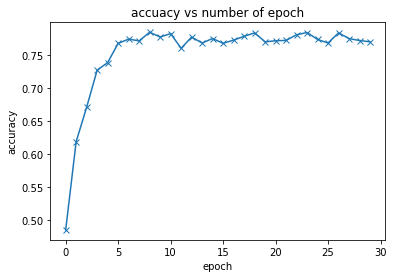

In [32]:
plot_accuracies(history)

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

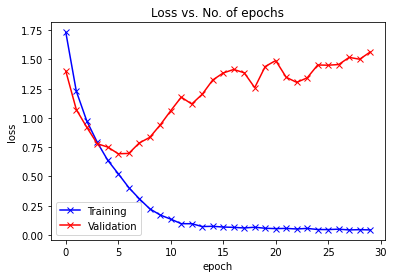

In [34]:
plot_losses(history)

In [35]:
test_dataset=ImageFolder(data_dir+'/test',transform=ToTensor())

In [36]:
def predict_image(img,model):
  xb=to_device(img.unsqueeze(0),device)
  yb=model(xb)
  _,preds=torch.max(torch.softmax(yb,dim=1),dim=1)
  return dataset.classes[preds[0].item()]


Label: airplane , Predicted: airplane


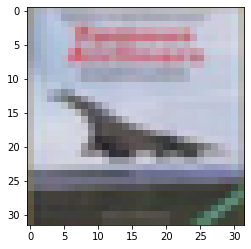

In [37]:
image,label=test_dataset[0]
plt.imshow(image.permute(1,2,0));
print('Label:',dataset.classes[label],', Predicted:',predict_image(image,model))

Label: bird , Predicted: bird


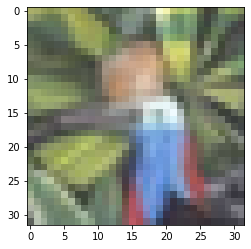

In [38]:
image,label=test_dataset[2022]
plt.imshow(image.permute(1,2,0));
print('Label:',dataset.classes[label],', Predicted:',predict_image(image,model))

Label: automobile , Predicted: automobile


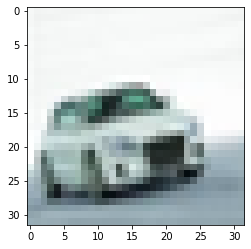

In [39]:
image,label=test_dataset[1803]
plt.imshow(image.permute(1,2,0));
print('Label:',dataset.classes[label],', Predicted:',predict_image(image,model))

In [40]:
test_loader=DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result=evaluate(model,test_loader)
result

{'val_loss': 1.5789580345153809, 'val_acc': 0.7645508050918579}